## Installing snntorch library

In [1]:
!pip install snntorch --quiet
!pip install -q kaggle
!pip install torchview -q
!pip install torchshape -q
!pip install gdown -q
!pip install matplotlib -q
!pip install scikit-learn -q
!pip install opencv-python


## Importing all the necessary tools

In [5]:
import numpy as np
import itertools
import cv2
import timeit
from os import listdir
import os
import zipfile
from zipfile import ZipFile
import gdown
import shutil

import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen

import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchview import draw_graph
from torchvision.transforms import ToTensor
from torchshape import tensorshape

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
from sklearn.metrics import classification_report

## Loading data from web and arranging in the filesystem
Before running the following code, make sure that you have loaded the file "kaggle.json" into the working directory. It should contain your API key to Kaggle. Also make sure that you have agreed to the rules for using the fingertips dataset. 
[Link](https://www.kaggle.com/datasets/ruizgara/socofing) to the SOCOFing dataset.

Unfortunately, you will not be able to run the code for fingerprints classification without this file. However, you can still use EMNIST and Fashion-MNIST datasets.

In [6]:
# 配置 kaggle.json 文件路径（假设在当前目录下）
kaggle_json_path = "./kaggle.json"
kaggle_destination_path = os.path.expanduser("~/.kaggle")

# 确保 .kaggle 目录存在
os.makedirs(kaggle_destination_path, exist_ok=True)

# 复制 kaggle.json 文件到 .kaggle
kaggle_json_dest = os.path.join(kaggle_destination_path, "kaggle.json")
if not os.path.exists(kaggle_json_dest):
    shutil.copy(kaggle_json_path, kaggle_json_dest)

# 修改权限确保安全
os.chmod(os.path.join(kaggle_destination_path, "kaggle.json"), 0o600)

from kaggle.api.kaggle_api_extended import KaggleApi

# 初始化 Kaggle API
api = KaggleApi()
# api.set_config_value(name="proxy", value="http://127.0.0.1:7897") #设置代理
api.authenticate()

# 下载数据集
dataset_name = "ruizgara/socofing"
output_zip_file = "socofing.zip"
if not os.path.exists(output_zip_file):
    print(f"Downloading dataset: {dataset_name}")
    api.dataset_download_files(dataset_name, path=".", quiet=False)

# 下载完成后初始化代理设置
api.unset_config_value(name="proxy")

# 创建解压目录
output_dir = "original_data"
os.makedirs(output_dir, exist_ok=True)

output_dir = "."

# 解压 ZIP 文件
if os.path.exists(output_zip_file):
    print(f"Extracting {output_zip_file} to {output_dir}")
    with zipfile.ZipFile(output_zip_file, 'r') as zip_ref:
        zip_ref.extractall(output_dir)
    print("Extraction complete.")
else:
    print(f"ZIP file {output_zip_file} not found.")

Extracting socofing.zip to .
Extraction complete.


In [7]:
# Load fingerprints dataset from kaggle and sort it
# Sort data inside train and test folders on classes folders named from 0 to 9
map_finger_name = ['left_thumb', 'left_index', 'left_middle', 'left_ring', 'left_little',
           'right_thumb', 'right_index', 'right_middle', 'right_ring', 'right_little']

# Working directories
load_dir = 'SOCOFing/'

datadir = './datasets/'
finger_dir = datadir + 'fingerprints/'
finger_train_dir = finger_dir + 'train/'
finger_val_dir = finger_dir + 'val/'
finger_test_dir = finger_dir + 'test/'

if not os.path.exists(finger_dir):
    # Create folders
    os.mkdir('./datasets')
    os.mkdir(finger_dir)
    os.mkdir(finger_train_dir)
    os.mkdir(finger_val_dir)
    os.mkdir(finger_test_dir)

    # Create folders for each class
    for i in range(10):
        os.mkdir(finger_train_dir + f"{i}/")
        os.mkdir(finger_val_dir + f"{i}/")
        os.mkdir(finger_test_dir + f"{i}/")

    # Move and sort by classes files of train dataset
    # for dir in ['Real/', 'Altered/Altered-Easy/']:
    for dir in ['Real/', 'Altered/Altered-Easy/']:
        for img in os.listdir(load_dir + dir):
            ind = max([i if map_finger_name[i] in img.lower() else -1 for i in range(len(map_finger_name))])
            shutil.copy2(load_dir + dir + img, finger_train_dir + f"{ind}/" + img)


## Data preprocessing


In [8]:
# Transforms for fingerprints
class CropInvertPadTransform:
    """
    Crop the frame (2*2*4*4) from the image, reformat to 1 channel, invert colors 
    and put black padding to the squared form. If the size is bigger, than the required, resize it
    """
    def __init__(self, size):
        self.size = size
        

    def __call__(self, x):
        """
        Transform the image by frame cropping, grayscaling and inverting
        Resize to the square by adding black padding

        :param x: tensor (image) to be transformed
        :return: transformed image
        """
        # Crop the frame 2 2 4 4 pixels
        x = TF.crop(x, 2, 2, TF.get_image_size(x)[1] - 6, TF.get_image_size(x)[0] - 6)
        x = TF.rgb_to_grayscale(x)
        x = TF.invert(x)

        # Add black padding to make the image square
        a = max(TF.get_image_size(x)) - TF.get_image_size(x)[0]
        b = max(TF.get_image_size(x)) - TF.get_image_size(x)[1]

        x = TF.pad(x, [a // 2, b // 2, a - a // 2, b - b // 2], fill=0)
        if TF.get_image_size(x)[0] > self.size:
            x = TF.resize(x, [self.size, self.size], antialias=True)
        return x

In [9]:
# Set transformations of images
# Transformations for fingerprints
from torchvision import transforms

fingerprints_transform = transforms.Compose([
    transforms.ToTensor(),
    CropInvertPadTransform(97),
    transforms.Normalize((0,), (1,))
])
# Define a transform for emnist and fashion mnist
mnist_transform = transforms.Compose([
            transforms.Resize((28, 28)),
            transforms.Grayscale(),
            transforms.ToTensor(),
            transforms.Normalize((0,), (1,))])

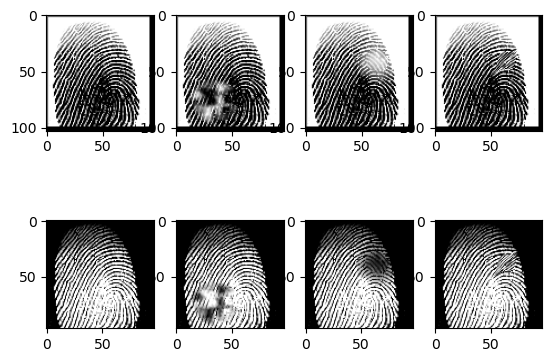

In [10]:
# Show example of fingerprint with alterations before and after transform
# Load the image

names = ['107__M_Left_index_finger.BMP', '107__M_Left_index_finger_Obl.BMP', '107__M_Left_index_finger_CR.BMP', '107__M_Left_index_finger_Zcut.BMP']

for i in range(len(names)):
    root='./datasets/fingerprints/'
    dirs = ['train/']
    for d in dirs:
        if names[i] in os.listdir(root+d+'1/'):
            break
    image = cv2.imread(finger_train_dir+'1/'+names[i])
    #Plot the original image
    plt.subplot(2, 4, i+1)
    # plt.title("Original")
    plt.imshow(image)

    #Plot the sharpened image
    plt.subplot(2, 4, i+5)
    
    arr = fingerprints_transform(image)[0].numpy()*255    
    plt.imshow(arr,cmap='gray')

plt.show()

### Transform - Datasets - Dataloaders

In [11]:
# Directories of datasets
datadir = './datasets/'
finger_dir = datadir + 'fingerprints/'
finger_train_dir = finger_dir + 'train/'
emnist_dir = datadir + 'emnist/'
fashion_dir = datadir + 'fashion_mnist/'

train_dir = 'train/'
val_dir = 'val/'
test_dir = 'test/'

# Split proportions
val_split = 0.1
test_split = 0.1
batch_size = 128

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [12]:
# Fingerprints

# Split on validation and test split
for finger_type in os.listdir(finger_train_dir):
    imgs = os.listdir(finger_train_dir + finger_type)
    # Split with shuffling
    np.random.shuffle(imgs)
    for img in imgs[:int(len(imgs) * test_split) + 1]:
        os.rename(finger_train_dir + finger_type + "/" + img, finger_dir + test_dir + finger_type + "/" + img)

    for img in imgs[int(len(imgs) * test_split) + 1:int(len(imgs) * test_split) + int(len(imgs) * val_split) + 2]:
        os.rename(finger_train_dir + finger_type + "/" + img, finger_dir + val_dir + finger_type + "/" + img)


# Set dataset
fingerprints_dataset = {'train': datasets.ImageFolder(root=finger_dir+train_dir, transform=fingerprints_transform),
                        'val': datasets.ImageFolder(root=finger_dir+val_dir, transform=fingerprints_transform),
                        'test': datasets.ImageFolder(root=finger_dir+test_dir, transform=fingerprints_transform)
}

# Set dataloader
fingerprints_dataloader = {'train': DataLoader(fingerprints_dataset['train'], batch_size=batch_size, shuffle=True, drop_last=True),
                        'val': DataLoader(fingerprints_dataset['val'], batch_size=batch_size, shuffle=True, drop_last=True),
                        'test': DataLoader(fingerprints_dataset['test'], batch_size=batch_size, shuffle=True, drop_last=True)
}

In [13]:
# EMNIST
# Set dataset
emnist_dataset = {'train': torchvision.datasets.EMNIST(emnist_dir+train_dir, 'digits', download=True, train=True, transform=mnist_transform),
                  'val': None,
                  'test': torchvision.datasets.EMNIST(emnist_dir+train_dir, 'digits',download=True, train=False, transform=mnist_transform)
}

# Validation split
emnist_dataset['train'], emnist_dataset['val'] = random_split(emnist_dataset['train'], [1-val_split, val_split])

# Set dataloaders
emnist_dataloader = {'train': DataLoader(emnist_dataset['train'], batch_size=batch_size, shuffle=True, drop_last=True),
                     'val': DataLoader(emnist_dataset['val'], batch_size=batch_size, shuffle=True, drop_last=True),
                     'test': DataLoader(emnist_dataset['test'], batch_size=batch_size, shuffle=True, drop_last=True)
}


100%|██████████| 562M/562M [00:24<00:00, 22.6MB/s] 


Extracting ./datasets/emnist/train/EMNIST\raw\gzip.zip to ./datasets/emnist/train/EMNIST\raw


In [14]:
# Fashion-MNIST
# Set dataset
fashion_dataset = {'train': torchvision.datasets.FashionMNIST(fashion_dir+train_dir, download=True, train=True, transform=mnist_transform),
                  'val': None,
                  'test': torchvision.datasets.FashionMNIST(fashion_dir+train_dir, download=True, train=False, transform=mnist_transform)
}

# Validation split
fashion_dataset['train'], fashion_dataset['val'] = random_split(fashion_dataset['train'], [1-val_split, val_split])

# Set dataloaders
fashion_dataloader = {'train': DataLoader(fashion_dataset['train'], batch_size=batch_size, shuffle=True, drop_last=True),
                     'val': DataLoader(fashion_dataset['val'], batch_size=batch_size, shuffle=True, drop_last=True),
                     'test': DataLoader(fashion_dataset['test'], batch_size=batch_size, shuffle=True, drop_last=True)
}


100%|██████████| 26.4M/26.4M [00:03<00:00, 7.32MB/s]


Extracting ./datasets/fashion_mnist/train/FashionMNIST\raw\train-images-idx3-ubyte.gz to ./datasets/fashion_mnist/train/FashionMNIST\raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 126kB/s]


Extracting ./datasets/fashion_mnist/train/FashionMNIST\raw\train-labels-idx1-ubyte.gz to ./datasets/fashion_mnist/train/FashionMNIST\raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 2.29MB/s]


Extracting ./datasets/fashion_mnist/train/FashionMNIST\raw\t10k-images-idx3-ubyte.gz to ./datasets/fashion_mnist/train/FashionMNIST\raw



100%|██████████| 5.15k/5.15k [00:00<?, ?B/s]

Extracting ./datasets/fashion_mnist/train/FashionMNIST\raw\t10k-labels-idx1-ubyte.gz to ./datasets/fashion_mnist/train/FashionMNIST\raw



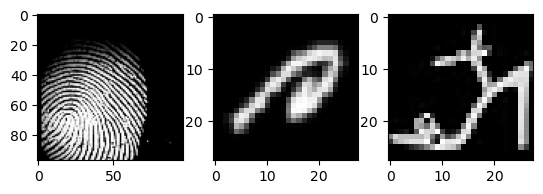

In [15]:
# Print one picture from each dataset
dataloaders = [fingerprints_dataloader, emnist_dataloader, fashion_dataloader]
for i in range(3):
    pic, _ = next(iter(dataloaders[i]['train']))
    pic = pic[0][0].numpy()*255 

    plt.subplot(1, 3, i+1)
    plt.imshow(pic, cmap='gray')

plt.show()

## Animations and visualizations of dataset

#### Rate coding

Spiking neural networks are designed to handle time-varying data. In this case, to use spike-based communication in the network, the input data should be encoded from the continuous value form into a time series of spikes.

In rate coding, each normalized value of input features is used to compute the probability that a spike will occur at any given time step, resulting in a discrete rate-encoded value. One may consider this as a Binomial distribution with number of trials equal to 1 and a probability of success (spike) equal to the normalized value of input feature.

In [16]:
%%capture
%matplotlib inline

# Batch of images from each dataset
img_finger, label_finger = next(iter(fingerprints_dataloader['train'])) 
img_e, label_e = next(iter(emnist_dataloader['train'])) 
img_fash, label_fash = next(iter(fashion_dataloader['train'])) 

# First image in the batch of images
img_finger, img_e, img_fash = img_finger[0][0], img_e[0][0], img_fash[0][0] 

# Set number of time steps and prbability of spike for most intensive pixel
num_steps = 100
gain = 1

# Encode image with rate coding
encoded_img_finger = spikegen.rate(img_finger, num_steps=num_steps, gain=gain)
encoded_img_e = spikegen.rate(img_e, num_steps=num_steps, gain=gain)
encoded_img_fash = spikegen.rate(img_fash, num_steps=num_steps, gain=gain)

# Base frame of image
fig, ax = plt.subplots(1,3, figsize = (12,4))
plt.tight_layout()
image_plot_finger = ax[0].imshow(img_finger, cmap='gray')
image_plot_e = ax[1].imshow(img_e, cmap='gray')
image_plot_fash = ax[2].imshow(img_fash, cmap='gray')

def init():
    """
    Initialization function
    Plot the background of each frame

    """
    image_plot_finger.set_data(img_finger)
    image_plot_e.set_data(img_e)
    image_plot_fash.set_data(img_fash)
    for x in ax:
      x.set_axis_off()
      
def animate(time):
    """
    Animation function; called sequantially

    :param time: time step
    """
    image_plot_finger.set_array(encoded_img_finger[time])
    image_plot_e.set_array(encoded_img_e[time])
    image_plot_fash.set_array(encoded_img_fash[time])
    ax[0].set_title(f'Fingerprint')
    ax[1].set_title(f'EMNIST')
    ax[2].set_title(f'Fashion-MNIST')

anim = FuncAnimation(fig, animate, init_func=init, frames=len(encoded_img_fash), interval=100)

In [17]:
htmlanim = anim.to_html5_video()
HTML(htmlanim)

#### Raster plot of diagonal pixels for fingerprint

Spike-coded images can be represented in form of raster plot, showing spikes of pixels at each time step

C:\Users\YcDen\AppData\Local\Temp\ipykernel_28536\1350157894.py:2: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:281.)
  raster_img = torch.Tensor([encoded_img_finger[:,i,i].numpy() for i in range(len(encoded_img_finger[0]))]).T


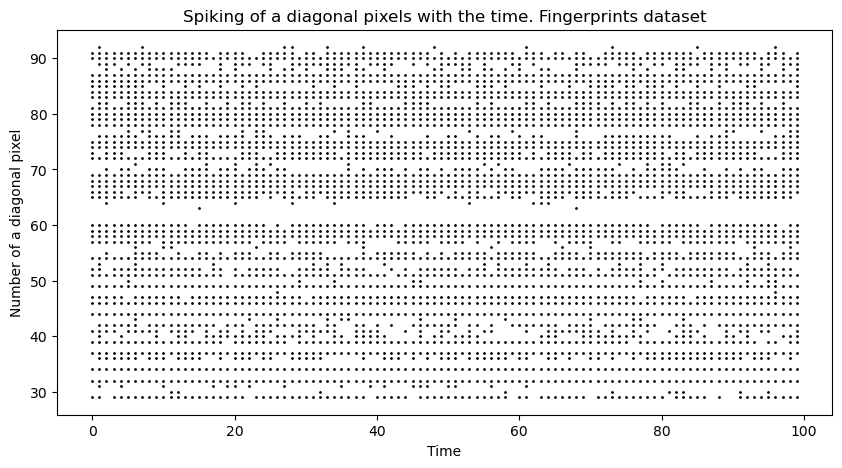

In [18]:
# Reshape image
raster_img = torch.Tensor([encoded_img_finger[:,i,i].numpy() for i in range(len(encoded_img_finger[0]))]).T

# Raster plot
fig = plt.figure(facecolor="w", figsize=(10, 5))
ax = fig.add_subplot(111)
ax.set_title('Spiking of a diagonal pixels with the time. Fingerprints dataset')
ax.set_xlabel('Time')
ax.set_ylabel('Number of a diagonal pixel')
splt.raster(raster_img, ax, s=1, color='black')

#### Membrane's potential

Leaky Integrate-and-Fire (LIF) neuron receives the sum of the weighted input signals. LIF integrates the inputs over time. If the integrated value exceeds a predefined threshold, the LIF neuron produces a spike.

As a result, the information is not stored in spikes, but rather in its frequency.

We plotted the behavior of an LIF neuron receiving input spikes over 100 time steps.

In [13]:
def add_x_ticks(ax):
    """
    Adding ticks

    :param ax: Axes object
    """ 
    ax.set_xticks(list(range(100))[::1])
    ax.tick_params(axis='x', which='major', labelsize=7)
    ax.set_yticks([])

def plot_spikes_with_potential(spikes, in_spikes, potential, 
                               title=None, threshold=1):
    """
    Plot input, output spikes and membrane potential

    :param spikes: output spikes
    :param in_spikes: input spikes
    :param potential: membrane potential
    :param title: title of plot
    :param threshold: value of threshold for membrane potential
    """
    # Unpacking Figure and Axes array
    fig, ax = plt.subplots(3,1, facecolor="w", figsize=(15, 5),
                          gridspec_kw={'height_ratios': [0.5, 4, 0.5]})
    ax[2].autoscale(tight=True)
    ax[1].autoscale(tight=True)
    ax[0].autoscale(tight=True)

    # Input spikes
    ax[0].set_title(f"{int(spikes.sum())} spikes and potential in neuron" if title==None else title)
    ax[0].set_ylabel("Input spikes")
    splt.raster(in_spikes, ax[0], s=200, c="black", marker="|")
    add_x_ticks(ax[0])

    # Output spikes
    splt.raster(spikes, ax[2], s=200, c="black", marker="|")
    ax[2].set_xlabel("Time")
    ax[2].set_ylabel("Output spikes")
    add_x_ticks(ax[2])

    # Membrane potential
    ax[1].plot(potential)
    ax[1].set_ylabel("Membrane potential")
    add_x_ticks(ax[1])

    times = []
    for i,spike in enumerate(spikes):
      if (spike != 0):
        times.append(i)

    ax[1].vlines(x = times, ymin = potential.min(), ymax = potential.max(), 
                 colors = 'gray', ls='dashed', lw=0.5)

    # Threshold line
    ax[1].axhline(y = threshold, color = 'r', linestyle = '--')

    fig.tight_layout()

In [14]:
# Leaky Integrate-and-Fire neuron
delta_t = 1e-3
tau = 5.1*5e-3
b = np.exp(-delta_t/tau)
lif = snn.Leaky(beta = b, threshold = 1.5)

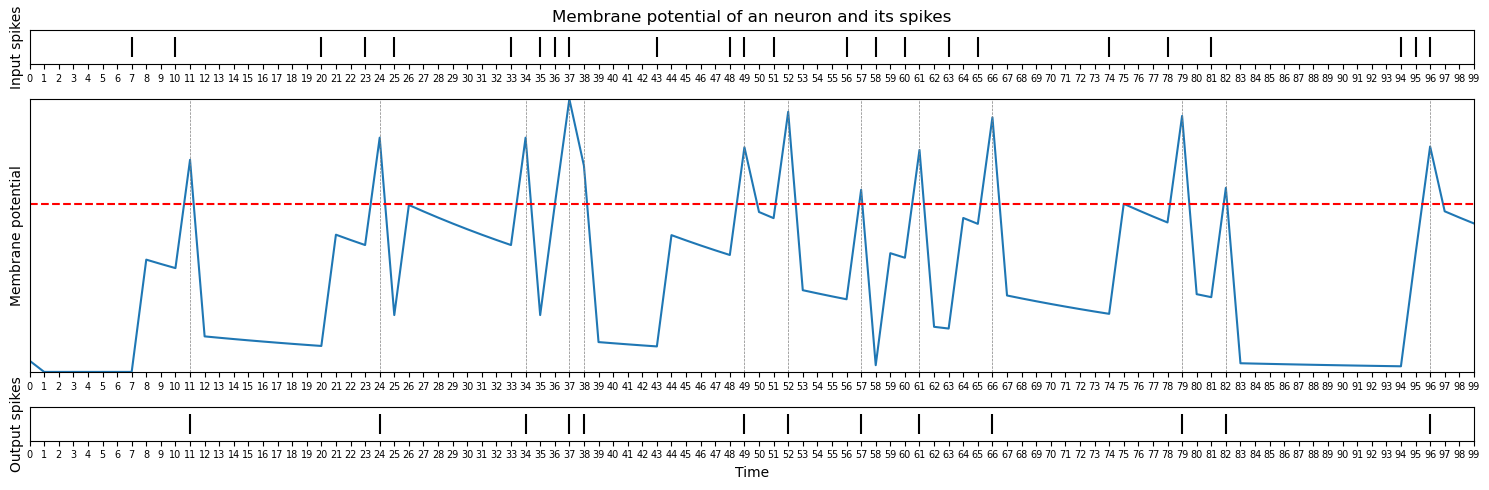

In [15]:
# Initialize input, output spikes and membrane potential
spk_in = spikegen.rate_conv(torch.ones((99))*0.2)
mem = torch.ones(1)*0.1
#print(mem)
spk = torch.zeros(1)
potential = [mem]
#print(potential)
spikes = [spk]

# Neuron simulation
for step in range(99):
  spk, mem = lif(spk_in[step], mem)
  #print(torch.tensor([mem.item()]))
  potential.append(torch.tensor([mem.item()]))
  spikes.append(torch.tensor([spk.item()]))

#print(spikes)
# Plot the spikes and membrane potential
potential = torch.stack(potential)
spikes = torch.stack(spikes)
plot_spikes_with_potential(spikes, spk_in, potential, 
                           title='Membrane potential of an neuron and its spikes', 
                           threshold = 1.5)

# Experiments

In [16]:
def training(model, train_loader, val_loader, optimizer, criterion, 
             device, epochs, tolerance = 3, min_delta = 0.01, 
             snn_mode = False, num_steps = None, path_load_model="model.pt"):
    """
    Training of model

    :param model: model to be trained
    :param train_loader: dataloader with train dataset
    :param val_loader: dataloader with validation dataset
    :param optimizer: optimizer
    :param criterion: loss function
    :param device: device on with model run
    :param epochs: number of epochs to be trained
    :param tolerance: number of epochs for stopping criteria
    :param min_delta: min validation loss delta between epochs for stopping criteria
    :param snn_mode: True - SNN training, False - ANN training
    :param num_steps: number of time steps for SNN
    :param path_load_model: path to save trained model
    :return: validation loss and accuracy history, time per epoch
    """
    epochs = epochs
    num_steps = num_steps
    time_delta = 0
    total_val_history = []
    accuracy_history = []
    best_accuracy = 0

    count = 0
    early_stop_val = np.inf
    
    start = timeit.default_timer()

    for epoch in range(epochs):
        # For "epochs" number of epochs
        model.train()

        train_loss, valid_loss = [], []
        total_train = 0
        correct_train = 0
        total_val = 0
        correct_val = 0

        for data, targets in train_loader:
            # For each batch of training set

            # Transfer to device
            data = data.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            
            
            if snn_mode:
                # For SNN models
                # Reshape data
                data = data.view(data.shape[0], -1)

                # Run model on batch and return output spike and membrane potential
                spike, potential = model(data)

                # Training loss of batch
                loss_val = torch.zeros((1), dtype=dtype, device=device)
                for step in range(num_steps):
                    loss_val += criterion(potential[step], targets)

                # Mean training loss
                loss_val /= num_steps

                # Decode output spikes to real-valued label
                _, predicted = spike.sum(dim=0).max(1)

                # Count number targets and correct identified labels
                total_train += targets.size(0)
                correct_train += (predicted == targets).sum().item()
            else:
                # For ANN models
                output = model(data)

                # Training loss of batch
                loss_val = criterion(output, targets)

                # Decode output spikes to real-valued label
                pred = output.argmax(dim=1, keepdim=True) 

                # Count number targets and correct identified labels
                total_train += targets.size(0)
                correct_train += pred.eq(targets.view_as(pred)).sum().item()

            # For next epoch
            loss_val.backward()
            optimizer.step()
            train_loss.append(loss_val.item())

        with torch.no_grad():
            # Validation phase
            model.eval()

            for data, targets in val_loader:
                # For each batch of validation set
                data = data.to(device)
                targets = targets.to(device)
                
                if snn_mode:
                    # For SNN models
                    # Reshape data
                    data = data.view(data.shape[0], -1)

                    # Run model on batch and return output spike and membrane potential
                    spike, potential = model(data)

                    # Validation loss of batch
                    loss_val = torch.zeros((1), dtype=dtype, device=device)
                    for step in range(num_steps):
                        loss_val += criterion(potential[step], targets)

                    # Mean validation loss
                    loss_val /= num_steps

                    # Decode output spikes to real-valued label
                    _, predicted = spike.sum(dim=0).max(1)

                    # Count number targets and correct identified labels
                    total_val += targets.size(0)
                    correct_val += (predicted == targets).sum().item()

                else:
                    # For ANN models
                    output = model(data)

                    # Validation loss of batch
                    loss_val = criterion(output, targets)
                    
                    # Decode output spikes to real-valued label
                    pred = output.argmax(dim=1, keepdim=True) 

                    # Count number targets and correct identified labels
                    total_val += targets.size(0)
                    correct_val += pred.eq(targets.view_as(pred)).sum().item()

                valid_loss.append(loss_val.item())

            # Early stopping
            if abs(early_stop_val - np.mean(valid_loss)) < min_delta:
                count += 1
            else:
                count = 0
            if count == tolerance:
                break

            early_stop_val = np.mean(train_loss)

            # Total validation loss and accuracy
            total_val_history.append(np.mean(valid_loss))
            accuracy_history.append(correct_val/total_val)

            # Save best model
            if best_accuracy <= accuracy_history[-1]:
                torch.save(model.state_dict(), path_load_model)

            print ("Epoch:", epoch, "\n\tTraining Loss:", np.mean(train_loss), 
                f"\n\tTraining Accuracy: {100 * correct_train/total_train:.2f}%", 
                "\n\tValidation Loss:", np.mean(valid_loss),
                f"\n\tValidation Accuracy: {100 * correct_val/total_val:.2f}%")
            
    stop = timeit.default_timer()
    time_delta = stop - start
    return total_val_history, accuracy_history, time_delta/(epoch + 1)


def testing(model, test_loader, device, snn_mode = False):
    """
    Testing of model

    :param model: model to be trained
    :param test_loader: dataloader with test dataset
    :param device: device on with model run
    :param snn_mode: True - SNN training, False - ANN training
    :return: true labels and predictions
    """
    total = 0
    correct = 0
    predictions = np.array([])
    true_labels = np.array([])

    with torch.no_grad():
        model.eval()
        for data, targets in test_loader:
            # For batch in test set
            data = data.to(device)
            targets = targets.to(device)
            
            if snn_mode:
                # SNN model
                # Output spikes
                test_spk, _ = model(data.view(data.size(0), -1))

                # Decode output spikes to real-valued label
                _, predicted = test_spk.sum(dim=0).max(1)
                predictions = np.concatenate((predictions, predicted.cpu()))
            

                total += targets.size(0)
                correct += (predicted == targets).sum().item()
            else:
                # ANN model
                output = model(data)

                predicted = output.argmax(dim=1, keepdim=True) 
                predictions = np.concatenate((predictions, predicted.cpu().numpy().reshape(1,-1)[0]))
            
                
                # Count number targets and correct identified labels
                total += targets.size(0)
                correct += predicted.eq(targets.view_as(predicted)).sum().item()

            true_labels = np.concatenate((true_labels, targets.cpu()))

    print(f"Total correctly classified test set images: {correct}/{total}")
    print(f"Test Set Accuracy: {100 * correct / total:.2f}%\n")
    return true_labels, predictions

In [17]:
class SNN(nn.Module):
    def __init__(self, num_inputs, num_outputs, 
                 num_hidden = 1024, num_steps = 25, 
                 beta = 0.95):
        """
        SNN with one hidden layer

        :param num_inputs: number of input units
        :param num_outputs: number of output units
        :param num_hidden: number of hidden units
        :param num_steps: number of time steps
        :param beta: beta coefficient value for Leaky model
        """
        super(SNN, self).__init__()

        # Initialize layers
        self.linear1 = nn.Linear(num_inputs, num_hidden)
        self.lif1 = snn.Leaky(beta=beta)
        self.linear2 = nn.Linear(num_hidden, num_outputs)
        self.lif2 = snn.Leaky(beta=beta)

        # Initialize number of time steps
        self.num_steps = num_steps

    def forward(self, x):
        """
        Forward step

        :param x: input values
        :return: output spikes and membrane potential
        """
        # Initialize hidden states at t=0
        potential1 = self.lif1.init_leaky()
        potential2 = self.lif2.init_leaky()
        
        # Record the output values
        output_spike = []
        output_potential = []

        for step in range(self.num_steps):
            # For each time step run through the SNN
            current1 = self.linear1(x)
            spike1, potential1 = self.lif1(current1, potential1)
            current2 = self.linear2(spike1)
            spike2, potential2 = self.lif2(current2, potential2)
            
            # Record outputs
            output_spike.append(spike2)
            output_potential.append(potential2)
        return torch.stack(output_spike, dim=0), torch.stack(output_potential, dim=0)

In [18]:
class CNN(nn.Module):
    def __init__(self, inputs_shape=(128, 1,97,97), num_outputs=10, 
                 num_hidden = 1024):
        """
        CNN with one fully-connected hidden layer

        :param inputs_shape: input shape of image
        :param num_outputs: number of output units
        :param num_hidden: number of hidden units
        """
        super(CNN, self).__init__()

        # First convolutional and max-pooling block
        self.conv1 = nn.Sequential(
            nn.Conv2d(1,16,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Second convolutional and max-pooling block
        self.conv2 = nn.Sequential(
            nn.Conv2d(16,32,3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Output shape
        outshape = [*tensorshape(self.conv2, tensorshape(self.conv1, inputs_shape))][1:]

        # Linear block
        self.linear1 = nn.Sequential(
            nn.Linear(np.prod(outshape), num_hidden),
            nn.ReLU(),
            nn.Linear(num_hidden, num_outputs)
        )

    def forward(self, x):
        """
        Forward step

        :param x: input values
        :return: output values
        """
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.linear1(x)
        return F.log_softmax(x, dim=1)

## Create models for different datasets


In [19]:
# Set parameters common for all models
max_epochs = 20
time_steps = 25
criterion = nn.CrossEntropyLoss

load_path =  "./save_model/"
if not os.path.exists(load_path):
    os.mkdir(load_path)

dtype = torch.float
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print(f'Device: {device}')

Device: cuda


### Fingerprints 



#### Create models

In [20]:
# Set parameters for this dataset

# Set input and output shapes
finger_input_shape = next(iter(fingerprints_dataloader['train']))[0].shape
finger_num_inputs = np.prod(finger_input_shape[-2:])
finger_num_outputs = len(np.unique(fingerprints_dataloader['train'].dataset.targets))

# Set path where to load the models
finger_snn_load_path = load_path + "finger_snn_model.pt"
finger_cnn_load_path = load_path + "finger_cnn_model.pt"

In [21]:
# Create SNN model
finger_snn = SNN(finger_num_inputs, finger_num_outputs).to(device)
finger_snn_optimizer = torch.optim.Adam(finger_snn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(finger_snn)

SNN(
  (linear1): Linear(in_features=9409, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


In [22]:
# Train SNN model
finger_snn_loss, finger_snn_accuracy, finger_snn_time = training(finger_snn, fingerprints_dataloader['train'], 
                                  fingerprints_dataloader['val'], finger_snn_optimizer, 
                                  criterion(), device, max_epochs, 
                                  snn_mode=True, num_steps=time_steps, path_load_model=finger_snn_load_path)

Epoch: 0 
	Training Loss: 1.9111511995328352 
	Training Accuracy: 37.56% 
	Validation Loss: 1.7465695871247187 
	Validation Accuracy: 45.31%
Epoch: 1 
	Training Loss: 1.558752757590889 
	Training Accuracy: 53.30% 
	Validation Loss: 1.5298621323373582 
	Validation Accuracy: 53.26%
Epoch: 2 
	Training Loss: 1.2969057263943973 
	Training Accuracy: 65.31% 
	Validation Loss: 1.3447941078080072 
	Validation Accuracy: 62.63%
Epoch: 3 
	Training Loss: 1.06253891903282 
	Training Accuracy: 75.06% 
	Validation Loss: 1.1823471784591675 
	Validation Accuracy: 70.83%
Epoch: 4 
	Training Loss: 0.8489595031578269 
	Training Accuracy: 83.10% 
	Validation Loss: 0.9599631726741791 
	Validation Accuracy: 76.69%
Epoch: 5 
	Training Loss: 0.6679372563458129 
	Training Accuracy: 89.29% 
	Validation Loss: 0.8109249439504411 
	Validation Accuracy: 83.94%
Epoch: 6 
	Training Loss: 0.525272419988709 
	Training Accuracy: 92.52% 
	Validation Loss: 0.7255413267347548 
	Validation Accuracy: 84.16%
Epoch: 7 
	Traini

In [23]:
# Create CNN model
finger_cnn = CNN(finger_input_shape, finger_num_outputs).to(device)
finger_cnn_optimizer = torch.optim.Adam(finger_cnn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(finger_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=15488, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [24]:
# Train CNN model
finger_cnn_loss, finger_cnn_accuracy, finger_cnn_time = training(finger_cnn, fingerprints_dataloader['train'], 
                                  fingerprints_dataloader['val'], finger_cnn_optimizer, 
                                  criterion(), device, max_epochs, snn_mode=False, path_load_model=finger_cnn_load_path)

Epoch: 0 
	Training Loss: 1.7308818693929071 
	Training Accuracy: 39.50% 
	Validation Loss: 1.449313097529941 
	Validation Accuracy: 49.00%
Epoch: 1 
	Training Loss: 1.2923204698818642 
	Training Accuracy: 55.00% 
	Validation Loss: 1.239549497763316 
	Validation Accuracy: 57.73%
Epoch: 2 
	Training Loss: 1.142120513740002 
	Training Accuracy: 59.71% 
	Validation Loss: 1.1479239397578769 
	Validation Accuracy: 58.98%
Epoch: 3 
	Training Loss: 1.053194342443607 
	Training Accuracy: 63.65% 
	Validation Loss: 1.0985790722899966 
	Validation Accuracy: 61.37%
Epoch: 4 
	Training Loss: 0.9814091256800914 
	Training Accuracy: 66.90% 
	Validation Loss: 1.0298907226986356 
	Validation Accuracy: 64.28%
Epoch: 5 
	Training Loss: 0.9201077938879896 
	Training Accuracy: 68.68% 
	Validation Loss: 0.9980389012230767 
	Validation Accuracy: 64.80%
Epoch: 6 
	Training Loss: 0.859535868935937 
	Training Accuracy: 71.22% 
	Validation Loss: 0.962383680873447 
	Validation Accuracy: 65.58%
Epoch: 7 
	Training

#### Load the best obtained models

In [25]:
# Load SNN model
finger_snn = SNN(finger_num_inputs, finger_num_outputs)
finger_snn.load_state_dict(torch.load(finger_snn_load_path))
finger_snn.to(device)

print(finger_snn)

SNN(
  (linear1): Linear(in_features=9409, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


C:\Users\YcDen\AppData\Local\Temp\ipykernel_21860\3473388853.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finger_snn.load_state_dict(torch.load(finger_snn_load_path))

In [26]:
# Load CNN model
finger_cnn = CNN(finger_input_shape, finger_num_outputs)
finger_cnn.load_state_dict(torch.load(finger_cnn_load_path))
finger_cnn.to(device)

print(finger_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=15488, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


C:\Users\YcDen\AppData\Local\Temp\ipykernel_21860\1930317060.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  finger_cnn.load_state_dict(torch.load(finger_cnn_load_path))

#### Analisys of the results obtained by the models
For each model print the avarage consumed time per epoch, number of correctly classified images and accuracy for test set, as well as classification report for it. 
Then plot validation loss and accuracy for each epoch during training.

In [27]:
print("Average time per epoch for SNN:", finger_snn_time, end=" sec\n")
print(classification_report(*testing(finger_snn, fingerprints_dataloader['test'], device, snn_mode = True)))

Average time per epoch for SNN: 20.86018073999985 sec
Total correctly classified test set images: 2222/2304
Test Set Accuracy: 96.44%

              precision    recall  f1-score   support

         0.0       0.88      0.98      0.93       230
         1.0       0.94      1.00      0.97       233
         2.0       0.97      1.00      0.98       232
         3.0       0.96      1.00      0.98       229
         4.0       0.98      0.96      0.97       226
         5.0       0.98      0.89      0.93       231
         6.0       0.97      0.93      0.95       230
         7.0       1.00      0.94      0.97       234
         8.0       0.99      0.96      0.97       229
         9.0       0.99      0.98      0.98       230

    accuracy                           0.96      2304
   macro avg       0.97      0.96      0.96      2304
weighted avg       0.97      0.96      0.96      2304



In [28]:
print("Average time per epoch for CNN:", finger_cnn_time, end=" sec\n")
print(classification_report(*testing(finger_cnn, fingerprints_dataloader['test'], device, snn_mode=False)))

Average time per epoch for CNN: 13.916416749999916 sec
Total correctly classified test set images: 2008/2304
Test Set Accuracy: 87.15%

              precision    recall  f1-score   support

         0.0       0.93      0.94      0.94       232
         1.0       0.86      0.83      0.85       228
         2.0       0.88      0.81      0.84       227
         3.0       0.87      0.82      0.84       228
         4.0       0.81      0.91      0.86       234
         5.0       0.98      0.97      0.98       231
         6.0       0.95      0.90      0.93       236
         7.0       0.72      0.94      0.82       232
         8.0       0.86      0.82      0.84       231
         9.0       0.91      0.76      0.83       225

    accuracy                           0.87      2304
   macro avg       0.88      0.87      0.87      2304
weighted avg       0.88      0.87      0.87      2304



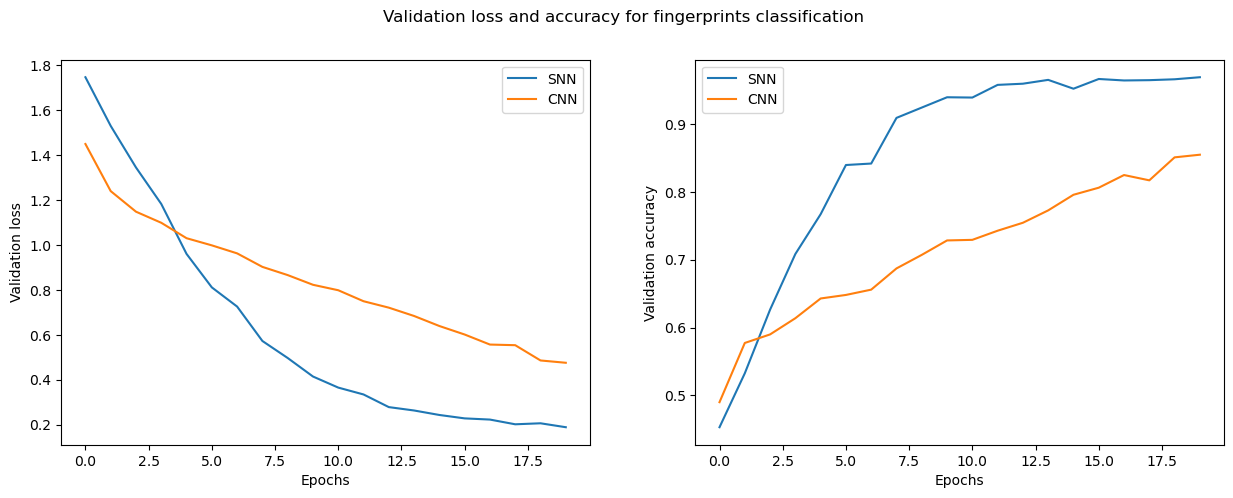

In [29]:
# Plot validation loss and accuracy for both models
plt.figure(figsize=(15, 5))

# Plot validation loss
plt.subplot(121)
plt.plot(finger_snn_loss)
plt.plot(finger_cnn_loss)

plt.ylabel('Validation loss')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

# Plot validation accuracy
plt.subplot(122)
plt.plot(finger_snn_accuracy)
plt.plot(finger_cnn_accuracy)

plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

plt.suptitle('Validation loss and accuracy for fingerprints classification')
plt.show()

### EMNIST 



#### Create models

In [30]:
# Set parameters for this dataset

# Set input and output shapes
emnist_input_shape = next(iter(emnist_dataloader['train']))[0].shape
emnist_num_inputs = np.prod(emnist_input_shape[-2:])
emnist_num_outputs = len(np.unique(emnist_dataloader['test'].dataset.targets))

# Set path where to load the models
emnist_snn_load_path = load_path + "emnist_snn_model.pt"
emnist_cnn_load_path = load_path + "emnist_cnn_model.pt"

In [31]:
# Create SNN model
emnist_snn = SNN(emnist_num_inputs, emnist_num_outputs).to(device)
emnist_snn_optimizer = torch.optim.Adam(emnist_snn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(emnist_snn)

SNN(
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


In [32]:
# Train SNN model
emnist_snn_loss, emnist_snn_accuracy, emnist_snn_time = training(emnist_snn, emnist_dataloader['train'], 
                                  emnist_dataloader['val'], emnist_snn_optimizer, 
                                  criterion(), device, max_epochs, 
                                  snn_mode=True, num_steps=time_steps, path_load_model=emnist_snn_load_path)

Epoch: 0 
	Training Loss: 0.3778955757388294 
	Training Accuracy: 91.12% 
	Validation Loss: 0.22070175234009237 
	Validation Accuracy: 95.63%
Epoch: 1 
	Training Loss: 0.1819274950668737 
	Training Accuracy: 96.62% 
	Validation Loss: 0.15770959268438625 
	Validation Accuracy: 97.36%
Epoch: 2 
	Training Loss: 0.13754387982918373 
	Training Accuracy: 97.84% 
	Validation Loss: 0.12758154545557052 
	Validation Accuracy: 98.08%
Epoch: 3 
	Training Loss: 0.1127719994663097 
	Training Accuracy: 98.38% 
	Validation Loss: 0.11143955713845191 
	Validation Accuracy: 98.21%
Epoch: 4 
	Training Loss: 0.09594999174915904 
	Training Accuracy: 98.57% 
	Validation Loss: 0.10367249894668074 
	Validation Accuracy: 98.46%
Epoch: 5 
	Training Loss: 0.08321389691958289 
	Training Accuracy: 98.77% 
	Validation Loss: 0.09566366272096966 
	Validation Accuracy: 98.56%


In [33]:
# Create CNN model
emnist_cnn = CNN(emnist_input_shape, emnist_num_outputs).to(device)
emnist_cnn_optimizer = torch.optim.Adam(emnist_cnn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(emnist_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=800, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [34]:
# Train CNN model
emnist_cnn_loss, emnist_cnn_accuracy, emnist_cnn_time = training(emnist_cnn, emnist_dataloader['train'], 
                                  emnist_dataloader['val'], emnist_cnn_optimizer, 
                                  criterion(), device, max_epochs, snn_mode=False, path_load_model=emnist_cnn_load_path)

Epoch: 0 
	Training Loss: 0.33321783334573274 
	Training Accuracy: 92.10% 
	Validation Loss: 0.09895086875135567 
	Validation Accuracy: 97.16%
Epoch: 1 
	Training Loss: 0.07355594255414388 
	Training Accuracy: 97.94% 
	Validation Loss: 0.05783727645057249 
	Validation Accuracy: 98.32%
Epoch: 2 
	Training Loss: 0.04832083983214326 
	Training Accuracy: 98.60% 
	Validation Loss: 0.04607194848856665 
	Validation Accuracy: 98.69%
Epoch: 3 
	Training Loss: 0.03822466029184382 
	Training Accuracy: 98.89% 
	Validation Loss: 0.037309241655437066 
	Validation Accuracy: 98.94%
Epoch: 4 
	Training Loss: 0.032443334395286724 
	Training Accuracy: 99.03% 
	Validation Loss: 0.03534364818849347 
	Validation Accuracy: 99.00%
Epoch: 5 
	Training Loss: 0.028499840930224053 
	Training Accuracy: 99.16% 
	Validation Loss: 0.032925579229987324 
	Validation Accuracy: 99.03%


#### Load best obtained models

In [35]:
# Load SNN model
emnist_snn = SNN(emnist_num_inputs, emnist_num_outputs)
emnist_snn.load_state_dict(torch.load(emnist_snn_load_path))
emnist_snn.to(device)

print(emnist_snn)

SNN(
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


C:\Users\YcDen\AppData\Local\Temp\ipykernel_21860\770261058.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emnist_snn.load_state_dict(torch.load(emnist_snn_load_path))


In [36]:
# Load CNN model
emnist_cnn = CNN(emnist_input_shape, emnist_num_outputs)
emnist_cnn.load_state_dict(torch.load(emnist_cnn_load_path))
emnist_cnn.to(device)

print(emnist_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=800, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


C:\Users\YcDen\AppData\Local\Temp\ipykernel_21860\3274586006.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  emnist_cnn.load_state_dict(torch.load(emnist_cnn_load_path))

#### Analisys of the results obtained by the models
For each model print the avarage consumed time per epoch, number of correctly classified images and accuracy for test set, as well as classification report for it. 
Then plot validation loss and accuracy for each epoch during training.

In [37]:
print("Average time per epoch for SNN:", emnist_snn_time, end=" sec\n")
print(classification_report(*testing(emnist_snn, emnist_dataloader['test'], device, snn_mode = True)))

Average time per epoch for SNN: 86.50047252857205 sec
Total correctly classified test set images: 39370/39936
Test Set Accuracy: 98.58%

              precision    recall  f1-score   support

         0.0       0.97      0.99      0.98      3994
         1.0       1.00      0.99      0.99      3993
         2.0       0.99      0.98      0.99      3994
         3.0       0.99      0.98      0.98      3994
         4.0       0.99      0.99      0.99      3997
         5.0       0.99      0.98      0.99      3994
         6.0       0.99      0.99      0.99      3990
         7.0       0.99      0.99      0.99      3994
         8.0       0.98      0.98      0.98      3994
         9.0       0.98      0.98      0.98      3992

    accuracy                           0.99     39936
   macro avg       0.99      0.99      0.99     39936
weighted avg       0.99      0.99      0.99     39936



In [38]:
print("Average time per epoch for CNN:", emnist_cnn_time, end=" sec\n")
print(classification_report(*testing(emnist_cnn, emnist_dataloader['test'], device, snn_mode=False)))

Average time per epoch for CNN: 32.94932484285736 sec
Total correctly classified test set images: 39592/39936
Test Set Accuracy: 99.14%

              precision    recall  f1-score   support

         0.0       1.00      0.99      0.99      3994
         1.0       0.99      1.00      0.99      3993
         2.0       0.99      0.99      0.99      3989
         3.0       0.99      0.99      0.99      3996
         4.0       0.99      0.99      0.99      3991
         5.0       0.99      0.99      0.99      3994
         6.0       1.00      0.99      0.99      3994
         7.0       0.99      0.99      0.99      3992
         8.0       0.98      0.99      0.99      3995
         9.0       0.99      0.99      0.99      3998

    accuracy                           0.99     39936
   macro avg       0.99      0.99      0.99     39936
weighted avg       0.99      0.99      0.99     39936



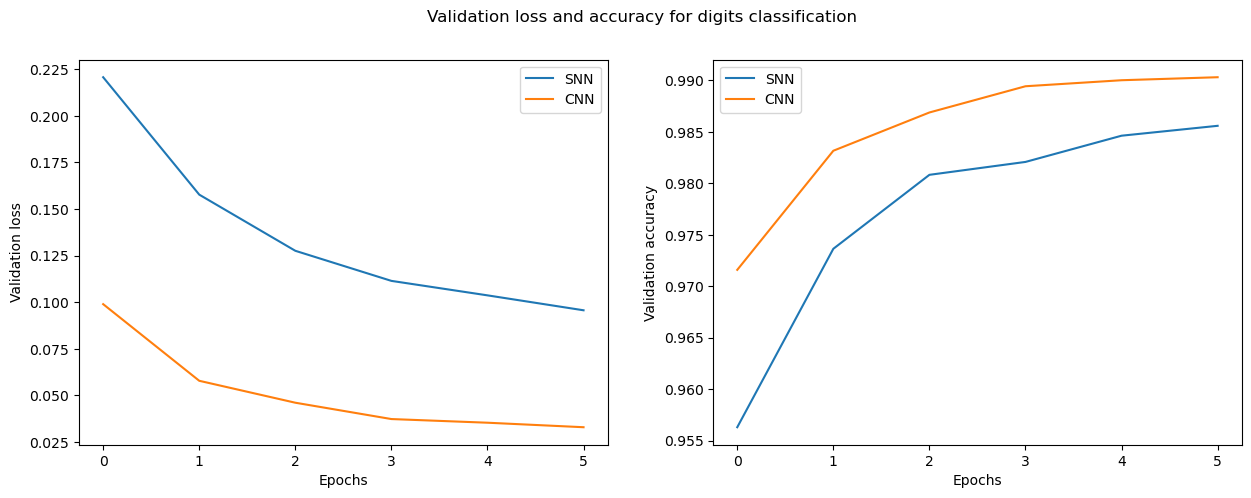

In [39]:
# Plot validation loss and accuracy for both models
plt.figure(figsize=(15, 5))

# Plot validation loss
plt.subplot(121)
plt.plot(emnist_snn_loss)
plt.plot(emnist_cnn_loss)

plt.ylabel('Validation loss')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

# Plot validation accuracy
plt.subplot(122)
plt.plot(emnist_snn_accuracy)
plt.plot(emnist_cnn_accuracy)

plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

plt.suptitle('Validation loss and accuracy for digits classification')
plt.show()

### Fashion MNIST



#### Create models

In [40]:
# Set parameters for this dataset

# Set input and output shapes
fashion_input_shape = next(iter(fashion_dataloader['train']))[0].shape
fashion_num_inputs = np.prod(fashion_input_shape[-2:])
fashion_num_outputs = len(np.unique(fashion_dataloader['test'].dataset.targets))

# Set path where to load the models
fashion_snn_load_path = load_path + "fashion_snn_model.pt"
fashion_cnn_load_path = load_path + "fashion_cnn_model.pt"

In [41]:
# Create SNN model
fashion_snn = SNN(fashion_num_inputs, fashion_num_outputs).to(device)
fashion_snn_optimizer = torch.optim.Adam(fashion_snn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(fashion_snn)

SNN(
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


In [42]:
# Train SNN model
fashion_snn_loss, fashion_snn_accuracy, fashion_snn_time = training(fashion_snn, fashion_dataloader['train'], 
                                  fashion_dataloader['val'], fashion_snn_optimizer, 
                                  criterion(), device, max_epochs, 
                                  snn_mode=True, num_steps=time_steps, path_load_model=fashion_snn_load_path)

Epoch: 0 
	Training Loss: 0.8389384193686578 
	Training Accuracy: 75.10% 
	Validation Loss: 0.625063581959061 
	Validation Accuracy: 79.79%
Epoch: 1 
	Training Loss: 0.592387109357784 
	Training Accuracy: 81.96% 
	Validation Loss: 0.5494777320519738 
	Validation Accuracy: 83.34%
Epoch: 2 
	Training Loss: 0.5350569795967565 
	Training Accuracy: 84.41% 
	Validation Loss: 0.5310774847217228 
	Validation Accuracy: 85.28%
Epoch: 3 
	Training Loss: 0.5023022132644744 
	Training Accuracy: 85.29% 
	Validation Loss: 0.5020078051349391 
	Validation Accuracy: 85.87%
Epoch: 4 
	Training Loss: 0.4743932033236406 
	Training Accuracy: 86.56% 
	Validation Loss: 0.48244369159574096 
	Validation Accuracy: 86.36%
Epoch: 5 
	Training Loss: 0.45647834843099827 
	Training Accuracy: 87.37% 
	Validation Loss: 0.48239769624627155 
	Validation Accuracy: 86.80%
Epoch: 6 
	Training Loss: 0.4395493195345736 
	Training Accuracy: 87.96% 
	Validation Loss: 0.4546592462321986 
	Validation Accuracy: 87.58%
Epoch: 7 
	T

In [43]:
# Create CNN model
fashion_cnn = CNN(fashion_input_shape, fashion_num_outputs).to(device)
fashion_cnn_optimizer = torch.optim.Adam(fashion_cnn.parameters(), lr=0.000085, betas=(0.9, 0.999))

print(fashion_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=800, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


In [44]:
# Train CNN model
fashion_cnn_loss, fashion_cnn_accuracy, fashion_cnn_time = training(fashion_cnn, fashion_dataloader['train'], 
                                  fashion_dataloader['val'], fashion_cnn_optimizer, 
                                  criterion(), device, max_epochs, snn_mode=False, path_load_model=fashion_cnn_load_path)

Epoch: 0 
	Training Loss: 1.0210286561497033 
	Training Accuracy: 68.43% 
	Validation Loss: 0.6477816921213398 
	Validation Accuracy: 75.39%
Epoch: 1 
	Training Loss: 0.5804081025429406 
	Training Accuracy: 78.33% 
	Validation Loss: 0.5320777102656986 
	Validation Accuracy: 80.55%
Epoch: 2 
	Training Loss: 0.511066963086502 
	Training Accuracy: 81.32% 
	Validation Loss: 0.4913951087257136 
	Validation Accuracy: 81.79%
Epoch: 3 
	Training Loss: 0.46779749611494376 
	Training Accuracy: 83.30% 
	Validation Loss: 0.45290987064009125 
	Validation Accuracy: 83.49%
Epoch: 4 
	Training Loss: 0.4383442916524665 
	Training Accuracy: 84.31% 
	Validation Loss: 0.43377526298813196 
	Validation Accuracy: 84.61%
Epoch: 5 
	Training Loss: 0.41704284599727803 
	Training Accuracy: 85.07% 
	Validation Loss: 0.40122155780377594 
	Validation Accuracy: 85.75%
Epoch: 6 
	Training Loss: 0.3988392591264072 
	Training Accuracy: 85.91% 
	Validation Loss: 0.38890556213648425 
	Validation Accuracy: 86.29%
Epoch: 7

#### Load best obtained models

In [50]:
# Load SNN model
fashion_snn = SNN(fashion_num_inputs, fashion_num_outputs)
fashion_snn.load_state_dict(torch.load(fashion_snn_load_path))
fashion_snn.to(device)

print(fashion_snn)

SNN(
  (linear1): Linear(in_features=784, out_features=1024, bias=True)
  (lif1): Leaky()
  (linear2): Linear(in_features=1024, out_features=10, bias=True)
  (lif2): Leaky()
)


C:\Users\YcDen\AppData\Local\Temp\ipykernel_21860\2215356817.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fashion_snn.load_state_dict(torch.load(fashion_snn_load_path

In [51]:
# Load CNN model
fashion_cnn = CNN(fashion_input_shape, fashion_num_outputs)
fashion_cnn.load_state_dict(torch.load(fashion_cnn_load_path))
fashion_cnn.to(device)

print(fashion_cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=800, out_features=1024, bias=True)
    (1): ReLU()
    (2): Linear(in_features=1024, out_features=10, bias=True)
  )
)


C:\Users\YcDen\AppData\Local\Temp\ipykernel_21860\353659375.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fashion_cnn.load_state_dict(torch.load(fashion_cnn_load_path)

#### Analisys of the results obtained by the models
For each model print the avarage consumed time per epoch, number of correctly classified images and accuracy for test set, as well as classification report for it. 
Then plot validation loss and accuracy for each epoch during training.

In [52]:
print("Average time per epoch for SNN:", fashion_snn_time, end=" sec\n")
print(classification_report(*testing(fashion_snn, fashion_dataloader['test'], device, snn_mode = True)))

Average time per epoch for SNN: 20.93613120500013 sec
Total correctly classified test set images: 8159/9984
Test Set Accuracy: 81.72%

              precision    recall  f1-score   support

         0.0       0.43      0.92      0.59      1000
         1.0       0.98      0.96      0.97       998
         2.0       0.82      0.75      0.79       998
         3.0       0.91      0.61      0.73      1000
         4.0       0.84      0.68      0.75       999
         5.0       0.98      0.95      0.96       999
         6.0       0.83      0.52      0.64       996
         7.0       0.94      0.94      0.94       999
         8.0       0.99      0.89      0.94       998
         9.0       0.94      0.95      0.95       997

    accuracy                           0.82      9984
   macro avg       0.87      0.82      0.83      9984
weighted avg       0.87      0.82      0.83      9984



In [53]:
print("Average time per epoch for CNN:", fashion_cnn_time, end=" sec\n")
print(classification_report(*testing(fashion_cnn, fashion_dataloader['test'], device, snn_mode=False)))

Average time per epoch for CNN: 8.788016962500024 sec
Total correctly classified test set images: 8689/9984
Test Set Accuracy: 87.03%

              precision    recall  f1-score   support

         0.0       0.83      0.82      0.83       999
         1.0       0.98      0.97      0.97       999
         2.0       0.82      0.77      0.80       997
         3.0       0.90      0.85      0.88       998
         4.0       0.76      0.84      0.80       996
         5.0       0.95      0.97      0.96      1000
         6.0       0.62      0.65      0.64       999
         7.0       0.95      0.91      0.93       997
         8.0       0.96      0.96      0.96      1000
         9.0       0.93      0.96      0.95       999

    accuracy                           0.87      9984
   macro avg       0.87      0.87      0.87      9984
weighted avg       0.87      0.87      0.87      9984



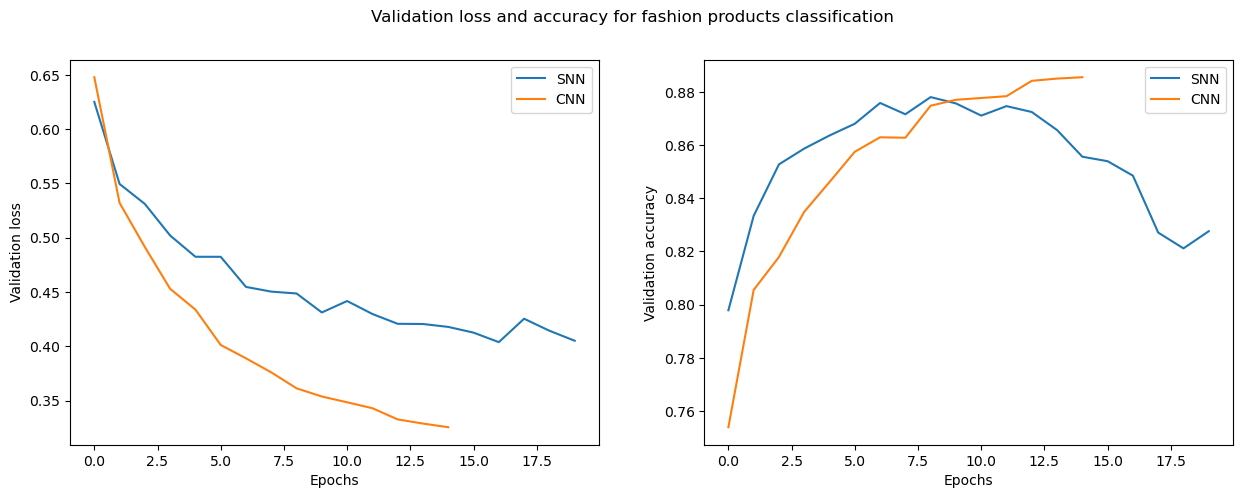

In [54]:
# Plot validation loss and accuracy for both models
plt.figure(figsize=(15, 5))

# Plot validation loss
plt.subplot(121)
plt.plot(fashion_snn_loss)
plt.plot(fashion_cnn_loss)

plt.ylabel('Validation loss')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

# Plot validation accuracy
plt.subplot(122)
plt.plot(fashion_snn_accuracy)
plt.plot(fashion_cnn_accuracy)

plt.ylabel('Validation accuracy')
plt.xlabel('Epochs')
plt.legend(['SNN', 'CNN'])

plt.suptitle('Validation loss and accuracy for fashion products classification')
plt.show()

## Results


For SOCOFing dataset SNN model outperformed the CNN model and obtained the 98% accuracy, in comparison with 83% for CNN. For both EMNIST, and Fashion-MNIST datasets SNN and CNN showed approximately the same results: 98% accuracy for EMNIST and 86% accuracy for Fashion-MNIST. However, training of one epoch for SNN was, on average, 1.5 times slower than for CNN.